## 1. Configuração Inicial

In [ ]:
# Instalação das bibliotecas (execute apenas uma vez)
# !pip install openai numpy scipy matplotlib scikit-learn python-dotenv requests beautifulsoup4 -q

In [1]:
import warnings
from dotenv import load_dotenv
from openai import OpenAI

# Importando funções do módulo local

from embedding_utils import (
    get_embedding,
    cosine_similarity,
    plot_embeddings_2d,
    buscar_wikipedia,
    dividir_em_chunks,
)

warnings.filterwarnings("ignore")

# Carrega variáveis do arquivo .env
load_dotenv()

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


In [2]:
# A chave da API é carregada automaticamente do arquivo .env
client = OpenAI()

print("✅ Cliente OpenAI configurado!")

✅ Cliente OpenAI configurado!


## 2. Funções para Buscar Conteúdo da Wikipedia

In [3]:
# As funções buscar_wikipedia e dividir_em_chunks foram importadas de embedding_utils.py
# Veja o arquivo para detalhes da implementação

print("✅ Funções de busca disponíveis!")
print("   - buscar_wikipedia(titulo): busca conteúdo de uma página da Wikipedia")
print("   - dividir_em_chunks(texto, tamanho_max): divide texto em pedaços menores")

✅ Funções de busca disponíveis!
   - buscar_wikipedia(titulo): busca conteúdo de uma página da Wikipedia
   - dividir_em_chunks(texto, tamanho_max): divide texto em pedaços menores


## 3. Buscando Conteúdo de Páginas da Wikipedia

Vamos buscar informações sobre alguns temas interessantes:

In [4]:
# Lista de páginas de pessoas para buscar
paginas = [
    "Lionel_Messi",
    "Albert_Einstein",
    "Isaac_Newton",
    "Stephen_Hawking",
    "Zinedine_Zidane",
    "Gregor_Mendel",
    "Charles_Darwin",
]

# Buscando conteúdo
conteudos = {}
for pagina in paginas:
    print(f"🔍 Buscando: {pagina}...")
    try:
        conteudos[pagina] = buscar_wikipedia(pagina)
        print(f"   ✓ {len(conteudos[pagina]['conteudo'])} parágrafos encontrados")
    except Exception as e:
        print(f"   ✗ Erro: {e}")

print(f"\n✅ {len(conteudos)} páginas carregadas!")

🔍 Buscando: Lionel_Messi...
   ✓ 120 parágrafos encontrados
🔍 Buscando: Albert_Einstein...
   ✓ 78 parágrafos encontrados
🔍 Buscando: Isaac_Newton...
   ✓ 83 parágrafos encontrados
🔍 Buscando: Stephen_Hawking...
   ✓ 36 parágrafos encontrados
🔍 Buscando: Zinedine_Zidane...
   ✓ 42 parágrafos encontrados
🔍 Buscando: Gregor_Mendel...
   ✓ 29 parágrafos encontrados
🔍 Buscando: Charles_Darwin...
   ✓ 90 parágrafos encontrados

✅ 7 páginas carregadas!


In [5]:
# Visualizando um exemplo de conteúdo
exemplo = list(conteudos.values())[0]
print(f"📄 Página: {exemplo['titulo']}")
print(f"🔗 URL: {exemplo['url']}")
print(f"\n📝 Primeiro parágrafo:")
print(exemplo["conteudo"][0][:500] + "...")

📄 Página: Lionel Messi
🔗 URL: https://pt.wikipedia.org/wiki/Lionel_Messi

📝 Primeiro parágrafo:
Lionel Andrés Messi Cuccittini (Rosário, 24 de junho de 1987) é um futebolista argentino que atua como atacante pelo Inter Miami. Como capitão da Seleção Argentina, venceu a Copa do Mundo de 2022 no Catar. Possui oito prêmios Bola de Ouro da France Football, oito títulos de Melhor Jogador do Mundo pela FIFA, dois Prêmios Laureus de Melhor Esportista, seis Chuteiras de Ouro da Europa e, com 48 conquistas coletivas, é o jogador com mais títulos oficiais da história do futebol....


In [6]:
exemplo

{'titulo': 'Lionel Messi',
 'conteudo': ['Lionel Andrés Messi Cuccittini (Rosário, 24 de junho de 1987) é um futebolista argentino que atua como atacante pelo Inter Miami. Como capitão da Seleção Argentina, venceu a Copa do Mundo de 2022 no Catar. Possui oito prêmios Bola de Ouro da France Football, oito títulos de Melhor Jogador do Mundo pela FIFA, dois Prêmios Laureus de Melhor Esportista, seis Chuteiras de Ouro da Europa e, com 48 conquistas coletivas, é o jogador com mais títulos oficiais da história do futebol.',
  'Considerado um dos melhores jogadores de todos os tempos, passou a maior parte de sua carreira profissional no Barcelona, onde se tornou o maior artilheiro por um único clube, com 672 gols oficiais e o maior vencedor da história do clube catalão, com 35 troféus. Entre suas conquistas, destacam-se os dez títulos do Campeonato Espanhol e as quatro Ligas dos Campeões da Europa. Teve ainda passagens por outros clubes, como o Paris Saint-Germain, onde conquistou o Campeonat

## 4. Criando Chunks e Gerando Embeddings

In [7]:
# Criando chunks de todos os conteúdos
todos_chunks = []
metadados = []  # Para saber de qual página veio cada chunk

for pagina, dados in conteudos.items():
    print(f"\n📄 Processando: {dados['titulo']}")

    # Junta todos os parágrafos e divide em chunks (com título da página como contexto)
    texto_completo = " ".join(dados["conteudo"])
    chunks = dividir_em_chunks(
        texto_completo, titulo_pagina=dados["titulo"], tamanho_max=1000, overlap=100
    )

    print(f"   → {len(chunks)} chunks criados")

    for chunk in chunks:
        todos_chunks.append(chunk)
        metadados.append({"pagina": dados["titulo"], "url": dados["url"]})

print(f"\n✅ Total: {len(todos_chunks)} chunks criados!")


📄 Processando: Lionel Messi
   → 66 chunks criados

📄 Processando: Albert Einstein
   → 81 chunks criados

📄 Processando: Isaac Newton
   → 47 chunks criados

📄 Processando: Stephen Hawking
   → 18 chunks criados

📄 Processando: Zinedine Zidane
   → 28 chunks criados

📄 Processando: Gregor Mendel
   → 18 chunks criados

📄 Processando: Charles Darwin
   → 79 chunks criados

✅ Total: 337 chunks criados!


In [32]:
# Gerando embeddings para todos os chunks
print("Gerando embeddings dos chunks...\n")

embeddings_chunks = []
for i, chunk in enumerate(todos_chunks):
    emb = get_embedding(client, chunk)
    embeddings_chunks.append(emb)

    # Progresso
    if (i + 1) % 10 == 0 or i == len(todos_chunks) - 1:
        print(f"   ✓ {i + 1}/{len(todos_chunks)} chunks processados")

print(f"\n✅ {len(embeddings_chunks)} embeddings gerados!")

# Salvando embeddings, metadados e chunks em arquivos para uso futuro
import numpy as np
import json

np.save("embeddings_chunks.npy", np.array(embeddings_chunks))
with open("metadados_chunks.json", "w", encoding="utf-8") as f:
    json.dump(metadados, f, ensure_ascii=False, indent=2)
with open("chunks.json", "w", encoding="utf-8") as f:
    json.dump(todos_chunks, f, ensure_ascii=False, indent=2)

print("💾 Dados salvos: embeddings_chunks.npy, metadados_chunks.json, chunks.json")

Gerando embeddings dos chunks...

   ✓ 10/337 chunks processados
   ✓ 20/337 chunks processados
   ✓ 30/337 chunks processados
   ✓ 40/337 chunks processados
   ✓ 50/337 chunks processados
   ✓ 60/337 chunks processados
   ✓ 70/337 chunks processados
   ✓ 80/337 chunks processados
   ✓ 90/337 chunks processados
   ✓ 100/337 chunks processados
   ✓ 110/337 chunks processados
   ✓ 120/337 chunks processados
   ✓ 130/337 chunks processados
   ✓ 140/337 chunks processados
   ✓ 150/337 chunks processados
   ✓ 160/337 chunks processados
   ✓ 170/337 chunks processados
   ✓ 180/337 chunks processados
   ✓ 190/337 chunks processados
   ✓ 200/337 chunks processados
   ✓ 210/337 chunks processados
   ✓ 220/337 chunks processados
   ✓ 230/337 chunks processados
   ✓ 240/337 chunks processados
   ✓ 250/337 chunks processados
   ✓ 260/337 chunks processados
   ✓ 270/337 chunks processados
   ✓ 280/337 chunks processados
   ✓ 290/337 chunks processados
   ✓ 300/337 chunks processados
   ✓ 310/337 ch

In [ ]:
# le os embeddings e metadados salvos
import numpy as np
import json

embeddings_chunks = np.load("embeddings_chunks.npy")
with open("metadados_chunks.json", "r") as f:
    metadados = json.load(f)
with open("chunks.json", "r", encoding="utf-8") as f:
    todos_chunks = json.load(f)

## 5. Visualização 2D dos Chunks

Vamos ver como os chunks de diferentes páginas se distribuem no espaço vetorial.

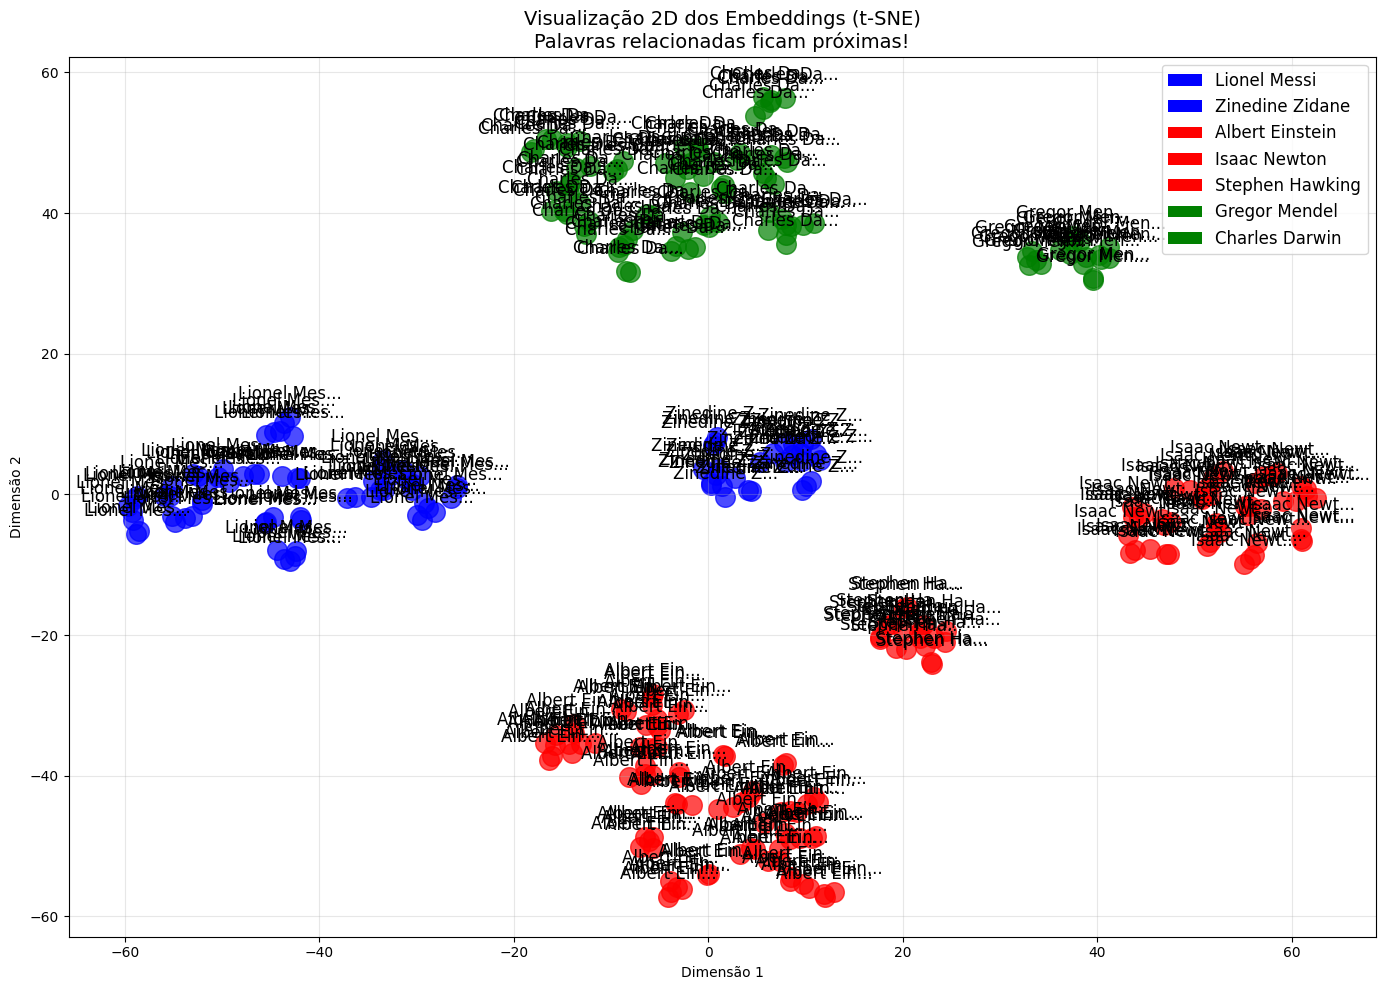


🎯 Observe como chunks do mesmo tema tendem a ficar próximos!


In [30]:
# Definindo cores por página
# Futebolistas em azul, biólogos em verde, físicos em vermelho
cores_paginas = {
    "Lionel Messi": "blue",
    "Zinedine Zidane": "blue",
    "Albert Einstein": "red",
    "Isaac Newton": "red",
    "Stephen Hawking": "red",
    "Gregor Mendel": "green",
    "Charles Darwin": "green",
}

cores_chunks = [cores_paginas.get(m["pagina"], "gray") for m in metadados]

# Configuração da legenda
legenda_config = [
    {"color": cor, "label": pagina} for pagina, cor in cores_paginas.items()
]

# Labels curtos para os chunks
labels_chunks = [f"{m['pagina'][:10]}..." for m in metadados]

# Visualização (pode demorar um pouco com muitos chunks)
if len(todos_chunks) <= 400:
    embeddings_2d = plot_embeddings_2d(
        palavras=labels_chunks,
        embeddings_list=embeddings_chunks,
        cores=cores_chunks,
        legenda_config=legenda_config,
        perplexity=min(8, len(todos_chunks) - 1),
        figsize=(14, 10),
    )
    print("\n🎯 Observe como chunks do mesmo tema tendem a ficar próximos!")
else:
    print(
        f"⚠️ Muitos chunks ({len(todos_chunks)}). Pulando visualização para economizar tempo."
    )

## 6. Sistema de Busca Semântica

In [13]:
def buscar_chunks_relevantes(pergunta: str, top_k: int = 3):
    """
    Busca os chunks mais relevantes para uma pergunta.

    Args:
        pergunta: A pergunta em linguagem natural
        top_k: Número de resultados a retornar

    Returns:
        Lista de tuplas (chunk, metadado, similaridade)
    """
    # Gera embedding da pergunta
    emb_pergunta = get_embedding(client, pergunta)

    # Calcula similaridade com todos os chunks
    resultados = []
    for i, emb_chunk in enumerate(embeddings_chunks):
        sim = cosine_similarity(emb_pergunta, emb_chunk)
        resultados.append((todos_chunks[i], metadados[i], sim))

    # Ordena por similaridade (maior primeiro)
    resultados.sort(key=lambda x: x[2], reverse=True)

    return resultados[:top_k]


def mostrar_resultados(pergunta: str, top_k: int = 3):
    """
    Mostra os resultados de busca de forma visual.
    """
    print(f"\n{'═' * 70}")
    print(f"❓ PERGUNTA: {pergunta}")
    print(f"{'═' * 70}")

    resultados = buscar_chunks_relevantes(pergunta, top_k)

    print(f"\n📊 Top {top_k} trechos mais relevantes:\n")

    for i, (chunk, meta, sim) in enumerate(resultados, 1):
        # Barra de progresso visual
        barra = "█" * int(sim * 30) + "░" * (30 - int(sim * 30))
        emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"

        print(f"{emoji} [{barra}] {sim:.1%}")
        print(f"   📄 Fonte: {meta['pagina']}")
        print(f"   📝 Trecho: {chunk[:200]}...")
        print()


print("✅ Sistema de busca pronto!")

✅ Sistema de busca pronto!


## 7. Testando a Busca Semântica

Agora vamos fazer perguntas sobre o conteúdo das páginas!

In [31]:
# Perguntas sobre Einstein
mostrar_resultados("Quem foi campeão mundial após disputa de pênaltis")


══════════════════════════════════════════════════════════════════════
❓ PERGUNTA: Quem foi campeão mundial após disputa de pênaltis
══════════════════════════════════════════════════════════════════════

📊 Top 3 trechos mais relevantes:

🥇 [███████████████░░░░░░░░░░░░░░░] 51.0%
   📄 Fonte: Lionel Messi
   📝 Trecho: [Lionel Messi] Apenas um minuto depois, Mbappé voltou a balançar as redes com um chute de primeira na entrada da área, empatando o confronto em 2–2 e levando a decisão para a prorrogação. Na prorrogaç...

🥈 [███████████████░░░░░░░░░░░░░░░] 50.7%
   📄 Fonte: Lionel Messi
   📝 Trecho: [Lionel Messi] A final da Copa do Mundo FIFA de 2022, disputada em 18 de dezembro, no Estádio Lusail, no Catar, entrou para a história como uma das decisões mais marcantes do futebol mundial. Diante d...

🥉 [██████████████░░░░░░░░░░░░░░░░] 49.7%
   📄 Fonte: Zinedine Zidane
   📝 Trecho: [Zinedine Zidane] A partida seguiu empatada, sem muitos chances de perigo, até o fim do tempo normal. Aos 13 m

In [ ]:
# Perguntas sobre IA
mostrar_resultados(
    "Onde estava Einstein quando passou mal devido a um problema no coração?"
)


══════════════════════════════════════════════════════════════════════
❓ PERGUNTA: Onde estava Einstein quando passou mal devido a um problema no coração?
══════════════════════════════════════════════════════════════════════

📊 Top 3 trechos mais relevantes:

🥇 [█████████████████████░░░░░░░░░] 70.4%
   📄 Fonte: Albert Einstein
   📝 Trecho: [Albert Einstein] Em março de 1928, durante uma viagem a Davos, Suíça, entrou em colapso com uma condição cardíaca grave. Confinado à cama por quatro meses, levou um ano para se recuperar totalmente. ...

🥈 [███████████████████░░░░░░░░░░░] 64.2%
   📄 Fonte: Albert Einstein
   📝 Trecho: [Albert Einstein] Seus últimos dias foram relativamente pacíficos. Morreu na manhã de segunda-feira em 18 de abril de 1955, no Hospital de Princeton à 1h15 da manhã, com 76 anos de idade, tendo contin...

🥉 [██████████████████░░░░░░░░░░░░] 61.2%
   📄 Fonte: Albert Einstein
   📝 Trecho: [Albert Einstein] Einstein pediu-lhes para ajudar a trazer cientistas judeus da Al

In [26]:
# Perguntas sobre IA
mostrar_resultados(
    "Onde estava Darwin quando passou mal devido a um problema no coração?"
)


══════════════════════════════════════════════════════════════════════
❓ PERGUNTA: Onde estava Darwin quando passou mal devido a um problema no coração?
══════════════════════════════════════════════════════════════════════

📊 Top 3 trechos mais relevantes:

🥇 [██████████████████████░░░░░░░░] 74.3%
   📄 Fonte: Charles Darwin
   📝 Trecho: [Charles Darwin] No resto de sua vida, ele apresentou problemas incapacitantes no estômago, desencadeando vômitos, palpitações, furúnculos, tremedeiras e outros sintomas. Os episódios se intensificava...

🥈 [█████████████████████░░░░░░░░░] 71.6%
   📄 Fonte: Charles Darwin
   📝 Trecho: [Charles Darwin] Atualmente, especula-se que Darwin sofria de uma doença de Chagas crônica. Essa especulação é baseada no trecho de um diário escrito por Darwin, que descreve que ele foi mordido por u...

🥉 [███████████████████░░░░░░░░░░░] 63.5%
   📄 Fonte: Charles Darwin
   📝 Trecho: [Charles Darwin] Ele posteriormente chamou sua teoria de seleção natural, uma analogia 

In [27]:
# Perguntas sobre IA
mostrar_resultados("Qual cientista teve problemas de saúde relacionados ao coração?")


══════════════════════════════════════════════════════════════════════
❓ PERGUNTA: Qual cientista teve problemas de saúde relacionados ao coração?
══════════════════════════════════════════════════════════════════════

📊 Top 3 trechos mais relevantes:

🥇 [███████████████░░░░░░░░░░░░░░░] 51.5%
   📄 Fonte: Albert Einstein
   📝 Trecho: [Albert Einstein] No entanto, recusou e escreveu em sua resposta que estava "profundamente comovido" e "ao mesmo tempo triste e envergonhado", pois não poderia aceitá-la: "Toda a minha vida eu tenho l...

🥈 [███████████████░░░░░░░░░░░░░░░] 50.5%
   📄 Fonte: Albert Einstein
   📝 Trecho: [Albert Einstein] Em março de 1928, durante uma viagem a Davos, Suíça, entrou em colapso com uma condição cardíaca grave. Confinado à cama por quatro meses, levou um ano para se recuperar totalmente. ...

🥉 [██████████████░░░░░░░░░░░░░░░░] 47.5%
   📄 Fonte: Charles Darwin
   📝 Trecho: [Charles Darwin] No resto de sua vida, ele apresentou problemas incapacitantes no estômago,

In [23]:
# Perguntas sobre Brasil
mostrar_resultados(
    "Quais plantas foram utilizadas nos primeiros estudos sobre herança genética?"
)


══════════════════════════════════════════════════════════════════════
❓ PERGUNTA: Quais plantas foram utilizadas nos primeiros estudos sobre herança genética?
══════════════════════════════════════════════════════════════════════

📊 Top 3 trechos mais relevantes:

🥇 [████████████████████░░░░░░░░░░] 69.2%
   📄 Fonte: Gregor Mendel
   📝 Trecho: [Gregor Mendel] Ele primeiro se concentrou na forma da semente, que era angular ou redonda. Entre 1856 e 1863 Mendel cultivou e testou cerca de 28 000 plantas, a maioria das quais eram plantas de ervi...

🥈 [███████████████████░░░░░░░░░░░] 66.0%
   📄 Fonte: Gregor Mendel
   📝 Trecho: [Gregor Mendel] Este debate entre os biometristas e os mendelianos foi extremamente vigoroso nas primeiras duas décadas do século XX, com os biometristas alegando rigor estatístico e matemático, enqua...

🥉 [███████████████████░░░░░░░░░░░] 65.3%
   📄 Fonte: Gregor Mendel
   📝 Trecho: [Gregor Mendel] Mendel também possuía um gene associado à epilepsia e a problemas n

## 8. Experimente você mesmo!

Faça suas próprias perguntas sobre Einstein, Inteligência Artificial ou Brasil!

In [28]:
# Digite sua pergunta aqui!
mostrar_resultados(
    "Quem foi levado as categorias de base de um clube espanhol quando adolescente?"
)


══════════════════════════════════════════════════════════════════════
❓ PERGUNTA: Quem foi levado as categorias de base de um clube espanhol quando adolescente?
══════════════════════════════════════════════════════════════════════

📊 Top 3 trechos mais relevantes:

🥇 [████████████████░░░░░░░░░░░░░░] 56.4%
   📄 Fonte: Lionel Messi
   📝 Trecho: [Lionel Messi] Como o Newell's não quis custear a continuação do tratamento, o pai ofereceu o filho ao River Plate. O interesse do clube da capital fez com que o Newell's voltasse atrás, mas de forma ...

🥈 [████████████████░░░░░░░░░░░░░░] 54.1%
   📄 Fonte: Lionel Messi
   📝 Trecho: [Lionel Messi] Messi ingressou na equipe após ser chamado pelo treinador para completar o time em uma partida, quando tinha apenas quatro anos. Posteriormente, seu pai, Jorge, seria seu treinador na c...

🥉 [████████████████░░░░░░░░░░░░░░] 53.5%
   📄 Fonte: Lionel Messi
   📝 Trecho: [Lionel Messi] Queria contratá-lo o quanto antes. Não podia deixá-lo escapar.” Messi

## 💡 O que aprendemos?

1. **Chunking** - Dividir textos grandes em pedaços menores é essencial para busca semântica eficiente
2. **Embeddings de chunks** - Cada trecho do texto tem sua própria representação vetorial
3. **Busca em conteúdo real** - O sistema funciona com textos reais da Wikipedia!
4. **Base para RAG** - Isso é exatamente o que sistemas RAG fazem antes de enviar contexto ao LLM

### 🚀 Próximo passo: RAG completo

Para um sistema RAG completo, combinaríamos:
1. **Busca semântica** (o que fizemos aqui) → encontrar trechos relevantes
2. **Prompt com contexto** → enviar os trechos junto com a pergunta
3. **LLM** → gerar uma resposta baseada no contexto

```python
# Exemplo de como seria o RAG completo:
contexto = buscar_chunks_relevantes(pergunta, top_k=3)
prompt = f"Contexto: {contexto}\n\nPergunta: {pergunta}\n\nResposta:"
resposta = client.chat.completions.create(messages=[{"role": "user", "content": prompt}])
```